## Load the Dataset

## Pandas:
**Pandas** is an open-source library built on top of Numpy and Matplotlib. It provides high-performance, easy-to-use data structures and data analysis tools.

A DataFrame is a two-dimensional data structure, i.e., data is aligned in a tabular fashion in rows and columns. Pandas DataFrame consists of three principal components, the data, rows, and columns.

Pandas DataFrame will be created by loading the datasets from existing MS Excel files, CSV files or SQL Database. Pandas DataFrame can also be created from the lists, dictionaries etc.


## Use Pandas to display the dataset


In [1]:
import pandas as pd
import matplotlib.pyplot as plt

train_data_raw = pd.read_csv("emotion_training.csv")
 
train_data_raw.head()

,text,label
0,i feel awful about it too because it s my job ...,sadness
1,im alone i feel awful,sadness
2,ive probably mentioned this before but i reall...,joy
3,i was feeling a little low few days back,sadness
4,i beleive that i am much more sensitive to oth...,love


<Axes: xlabel='label'>

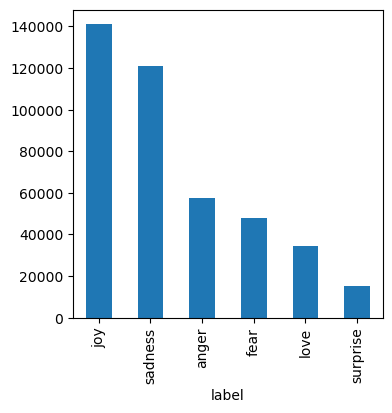

In [2]:
train_data_raw.label.value_counts().plot(kind='bar', figsize=(4, 4))

## Giving labels to Emotions

In [ ]:
train_data_raw["label"].unique()

In [ ]:
encode_emotions = {"anger": 0, "fear": 1, "joy": 2, "love": 3, "sadness": 4, "surprise": 5}

In [ ]:
train_data_raw.replace(encode_emotions, inplace = True)
train_data_raw.head()

## Convert Dataframe to list of dataset

In [ ]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(train_data_raw, test_size=0.25)

train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

print("Train: ", len(train), "Test: ", len(test))

In [ ]:
train, test

In [ ]:
training_sentences = []
training_labels = []

testing_sentences = []
testing_labels = []

for i in range(len(train)):

  tr_sentence = train.loc[i, "text"]
  training_sentences.append(tr_sentence)

  tr_label = train.loc[i, "label"]
  training_labels.append(tr_label)
    
for i in range(len(test)):
    
  ts_sentence = test.loc[i, "text"]
  testing_sentences.append(ts_sentence)

  ts_label = test.loc[i, "label"]
  testing_labels.append(ts_label)

In [ ]:
print("# of Training Sentences: ", len(training_sentences), "# of Training Labels: ", len(training_labels))
print("# of Testing Sentences: ", len(testing_sentences), "# of Testing Labels: ", len(testing_labels))

In [ ]:
training_sentences = [str (item) for item in training_sentences]
testing_sentences = [str (item) for item in testing_sentences]

In [ ]:
# checking the lists.
print('Random Training Sample: ', training_sentences[1], training_labels[1])
print('Random Testing Sample: ', testing_sentences[1], testing_labels[1])

## Tokenization & Padding

The act of converting text into numbers is known as **Tokenization**. The **Tokenizer** class of Keras is used for encoding text input into integer sequence.

**Padding** It is important to make all the sentences contain the same number of words. Zero is used for padding the tokenized sequence to make text contain the same number of tokens.


In [ ]:
#import Tokenizer from tensorflow

import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer

#Define parameters for Tokenizer

vocab_size = 40000
embedding_dim = 100
oov_tok = "<OOV>"
training_size = 20000

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)

tokenizer.fit_on_texts(training_sentences)
tokenizer.fit_on_texts(testing_sentences)

#Create a word_index dictionary

word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
testing_sequences = tokenizer.texts_to_sequences(testing_sentences)

In [ ]:
print('Train Seqs')
print(training_sequences[0])
print(training_sequences[1])
print(training_sequences[2])

In [ ]:
print('Test Seqs')
print(testing_sequences[0])
print(testing_sequences[1])
print(testing_sequences[2])

In [ ]:
#Define parameters for pad_sequences

from tensorflow.keras.preprocessing.sequence import pad_sequences

padding_type='post'
max_length = 100
trunc_type='post'


training_padded = pad_sequences(training_sequences, maxlen=max_length,
                                padding=padding_type, truncating=trunc_type)

testing_padded = pad_sequences(testing_sequences, maxlen=max_length,
                                padding=padding_type, truncating=trunc_type)

training_padded, testing_padded

## Converting padded sequences and labels into an Numpy array

In [ ]:
import numpy as np

training_padded = np.array(training_padded)
training_labels = np.array(training_labels)

testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

## Model Compilation


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.layers import Conv1D, Dropout, MaxPooling1D

model = tf.keras.Sequential([
        Embedding(vocab_size, embedding_dim, input_length=max_length),
        Dropout(0.2),

        Conv1D(filters = 256, kernel_size = 3, activation = "relu"),
        MaxPooling1D(pool_size = 3),

        Conv1D(filters = 128, kernel_size = 3, activation = "relu"),
        MaxPooling1D(pool_size = 3),

        LSTM(128),

        Dense(128, activation = "relu"),
        Dropout(0.2),
        Dense(64, activation = "relu"),
        Dense(6, activation = "softmax")])

model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

## Model Summary

In [ ]:
model.summary()

## Train Model

In [ ]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
num_epochs = 10
early_stopping = EarlyStopping(monitor='loss', patience=3, restore_best_weights=True)
history = model.fit(training_padded, training_labels, epochs=num_epochs, verbose=1, callbacks=[early_stopping])

In [ ]:
print("Evaluation on test data")
loss, accuracy = model.evaluate(testing_padded, testing_labels)
print("test loss: ", loss, "test accuracy: ", accuracy)

## Test the model

In [ ]:
sentence = ["I am happy to meet my friends.",
            "I had a bad day at school."]

sequences = tokenizer.texts_to_sequences(sentence)

padded = pad_sequences(sequences, maxlen=max_length,
                       padding=padding_type, truncating=trunc_type)
 
result=model.predict(padded)

predict_class = np.argmax(result, axis=1)
predict_class

emotion_labels = {0: "anger", 1: "fear", 2: "joy", 3: "love", 4: "sadness", 5: "surprise"}
predicted_emotions = [emotion_labels[class_index] for class_index in predict_class]

# Display the predicted emotions for each sentence
for i, emotion in enumerate(predicted_emotions):
    print(f"Sentence {i+1}: Predicted Emotion - {emotion}")

In [ ]:
model.save('Emotion_AI_Classifier.h5')